# Import Libraries

In [5]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

# Data Loading

In [8]:
datasets_paths = glob("../data/*.csv")
datasets: List[pd.DataFrame] = [pd.read_csv(path) for path in datasets_paths]

# Data Exploration

## Data Structure

In [9]:
datasets[0].head()

,value,timestamp,anomaly
0,0.416510,2021-07-01 00:00:00,False
1,0.573428,2021-07-01 01:00:00,True
2,0.536902,2021-07-01 02:00:00,False
3,-0.579474,2021-07-01 03:00:00,True
4,0.707928,2021-07-01 04:00:00,False


In [11]:
datasets[5].head()

,value,timestamp
0,-0.470214,2021-07-01
1,0.349970,2021-07-02
2,0.626234,2021-07-03
3,0.780888,2021-07-04
4,-0.023036,2021-07-05


In [13]:
train_anomaly = datasets[0]
train_no_anomaly = datasets[5]

**Note**: The datasets have different schemas
- `value`: The value of the observation
- `timestamp`: The timestamp of the observation
- `anomaly`: Whether the observation is an anomaly or not (Not all datasets have this column so we will assume that all observations are not anomalies)

**Todo**: Remove the records with `anomaly` = `True` from the datasets, and then remove the `anomaly` column

## Data Types

In [15]:
train_anomaly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3024 entries, 0 to 3023
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   value      2872 non-null   float64
 1   timestamp  3024 non-null   object 
 2   anomaly    3024 non-null   bool   
dtypes: bool(1), float64(1), object(1)
memory usage: 50.3+ KB


In [16]:
train_no_anomaly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   value      100 non-null    float64
 1   timestamp  105 non-null    object 
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


**Note**: 
- The timestamp column is in the `object` datatype.
- The timestamp column is not the index of the dataframe.

**Todo**
- Convert the timestamp column to the `datetime` datatype
- Set the timestamp column as the index of the dataframe


## Missing values 

In [21]:
train_anomaly.isna().sum()

value        152
timestamp      0
anomaly        0
dtype: int64

In [20]:
train_no_anomaly.isna().sum()

value        5
timestamp    0
dtype: int64

In [58]:
# Missing values for all datasets
datasets_missing_values_ratio = pd.Series(
    map(lambda df: df.isna().sum().value / df.shape[0], datasets)
)

In [59]:
datasets_missing_values_ratio.describe()

count    96.000000
mean      0.049596
std       0.006177
min       0.023810
25%       0.047867
50%       0.049951
75%       0.052100
max       0.071429
dtype: float64

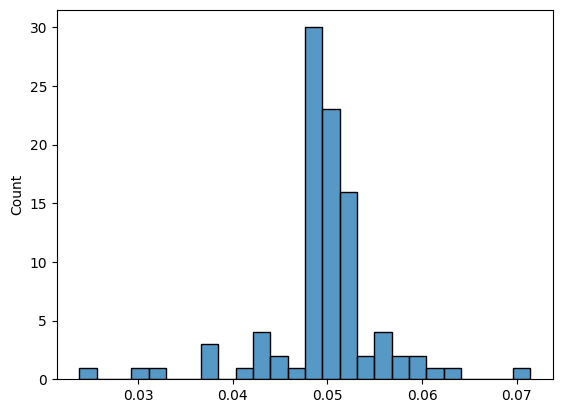

In [60]:
sns.histplot(datasets_missing_values_ratio)
plt.show()

**Note**: On average there are 5% of missing values in the datasets

**Todo**: Try different methods to fill in the missing data
- Forward fill
- Backward fill
- Interpolation (Linear, Quadratic, Cubic)
- Mean


# Outlier Detection

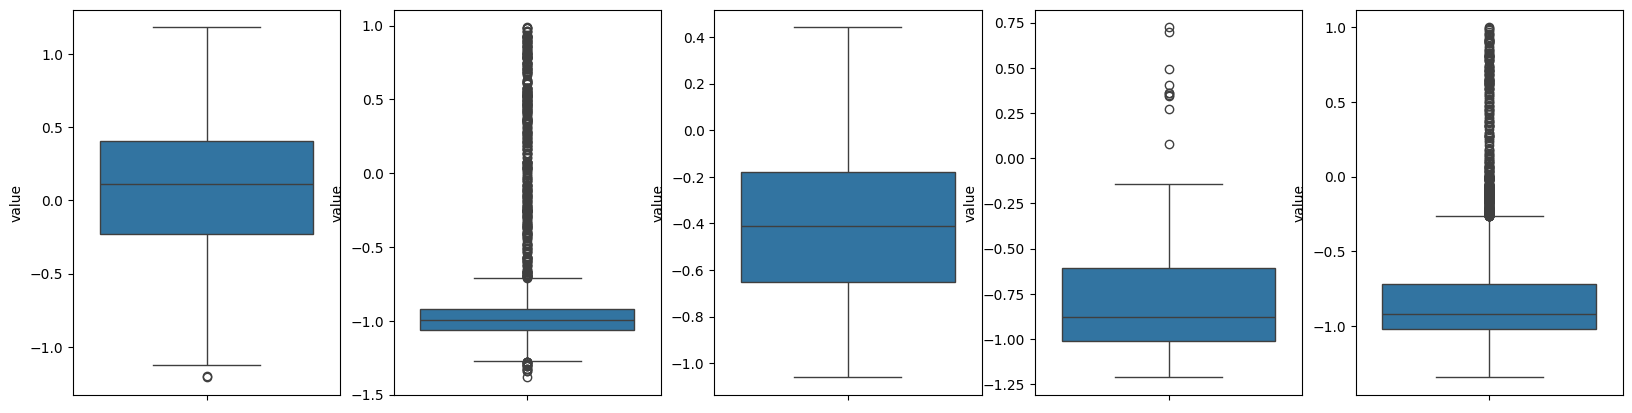

In [69]:
n = 5
fig, axis = plt.subplots(1, n, figsize=(20, 5))

for ax, dataset in zip(axis, datasets[:n]):
    sns.boxplot(ax=ax, data=dataset.value)
plt.show()

**Note**: From the Box-plot, there are uneven distributions of outliers in the datasets

**Todo**: Remove the outliers using the following methods
- Z-score
- Standard deviation
- Time Series decomposition

In [90]:
from statsmodels.tsa.seasonal import seasonal_decompose

train_anomaly_no_na = datasets[1].copy().dropna()
train_anomaly_no_na["timestamp"] = pd.to_datetime(train_anomaly_no_na["timestamp"])

In [91]:
train_anomaly_no_na = train_anomaly_no_na.set_index("timestamp")

In [93]:
train_anomaly_no_na

,value,anomaly
timestamp,,
2021-07-01 00:00:00,-1.055305,False
2021-07-01 00:10:00,-0.913538,False
2021-07-01 00:20:00,-0.992666,False
2021-07-01 00:30:00,-1.017343,False
2021-07-01 00:40:00,-1.164533,False
...,...,...
2021-09-01 23:10:00,-0.872683,False
2021-09-01 23:20:00,-0.864890,False
2021-09-01 23:30:00,-1.050328,False


In [98]:
train_anomaly_no_na["time_interval"] = train_anomaly_no_na.index.to_series().diff()
train_anomaly_no_na.time_interval.mode()

0   0 days 00:10:00
Name: time_interval, dtype: timedelta64[ns]

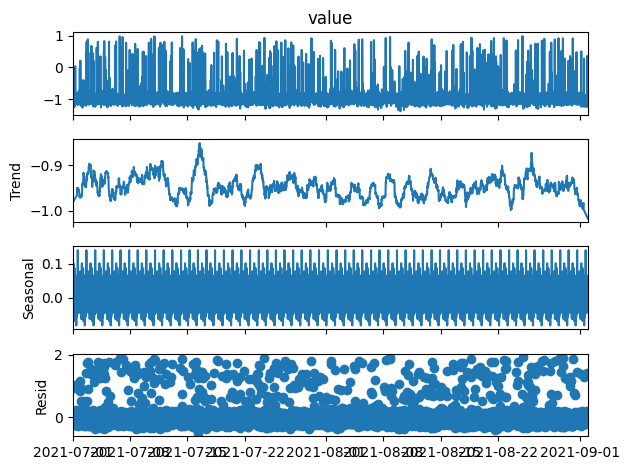

In [101]:
seasonal_decompose(
    train_anomaly_no_na.value, extrapolate_trend="freq", period=144
).plot()
plt.show()